## Imports

In [1]:
# can be used to install archtype analysis
import sys
# !pip install py_pcha

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn import preprocessing
from pathlib import Path
import scipy.io
import py_pcha

## Load dataset

In [3]:
path = Path().cwd()

data_path = path.parent / "Matlab" / "Data" / "zipdata.mat"
mat = scipy.io.loadmat(data_path)

traindata = mat['traindata']
testdata = mat['testdata']

n, p = np.shape(traindata)

print(f'number of observations: {n}, number of features: {p}')

Ntrain = 2000 # number of observations to use from train set
Ntest = 500 # number of observations to use from test set 

ytrain = traindata[0:Ntrain,0]
ytest = testdata[0:Ntest,0]
Xtrain = traindata[0:Ntrain,1:]
Xtest = testdata[0:Ntest,1:]
minX = np.min(np.min(Xtrain))
Xtrain=Xtrain-minX # Make sure X is non-negative (required for NMF)
Xtest=Xtest-minX;

k = 5 # number of nearest neighbours
lbda = .1 # L1 regularization used for SC and NSC

n_rows = 7 #for plotting
n_cols = 7 #for plotting

number of observations: 7291, number of features: 257


### Helper Functions

In [12]:
a = [1,2,3,4,5]
a[:50]

[1, 2, 3, 4, 5]

In [13]:
left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
image_shape = (16, 16)
# Function for plotting images
def plot_components(title, components):
    plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    start_index = random.randint(0, n)
    for i, comp in enumerate(components[:(n_rows*n_cols)]):
        # if (i+1) > (n_rows*n_cols):
        #     break
        plt.subplot(n_rows, n_cols, i + 1)
        # normalize colormap
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_recons(X, title, Nplot=100):
    plt.figure(figsize=(2. * 10, 2.26 * 10))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        # normalize colormap
        idx = random.randint(0, 499)
        comp = X[idx,:]
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

### 2 Classification is an important problem in data mining. A simple and widely used classificationapproach is based on K-nearest neighbor (KNN). We will initially investigate if dimensionalityreduction improves on classification of handwritten digits. Inspect the script ex2.m. Tryanalyzing the data using SVD with 25, 49, 100 and 256 components. What number ofcomponents results in the best classification performance? How will you describe thefeatures extracted by SVD?

In [10]:
Xtrain.shape

(2000, 256)

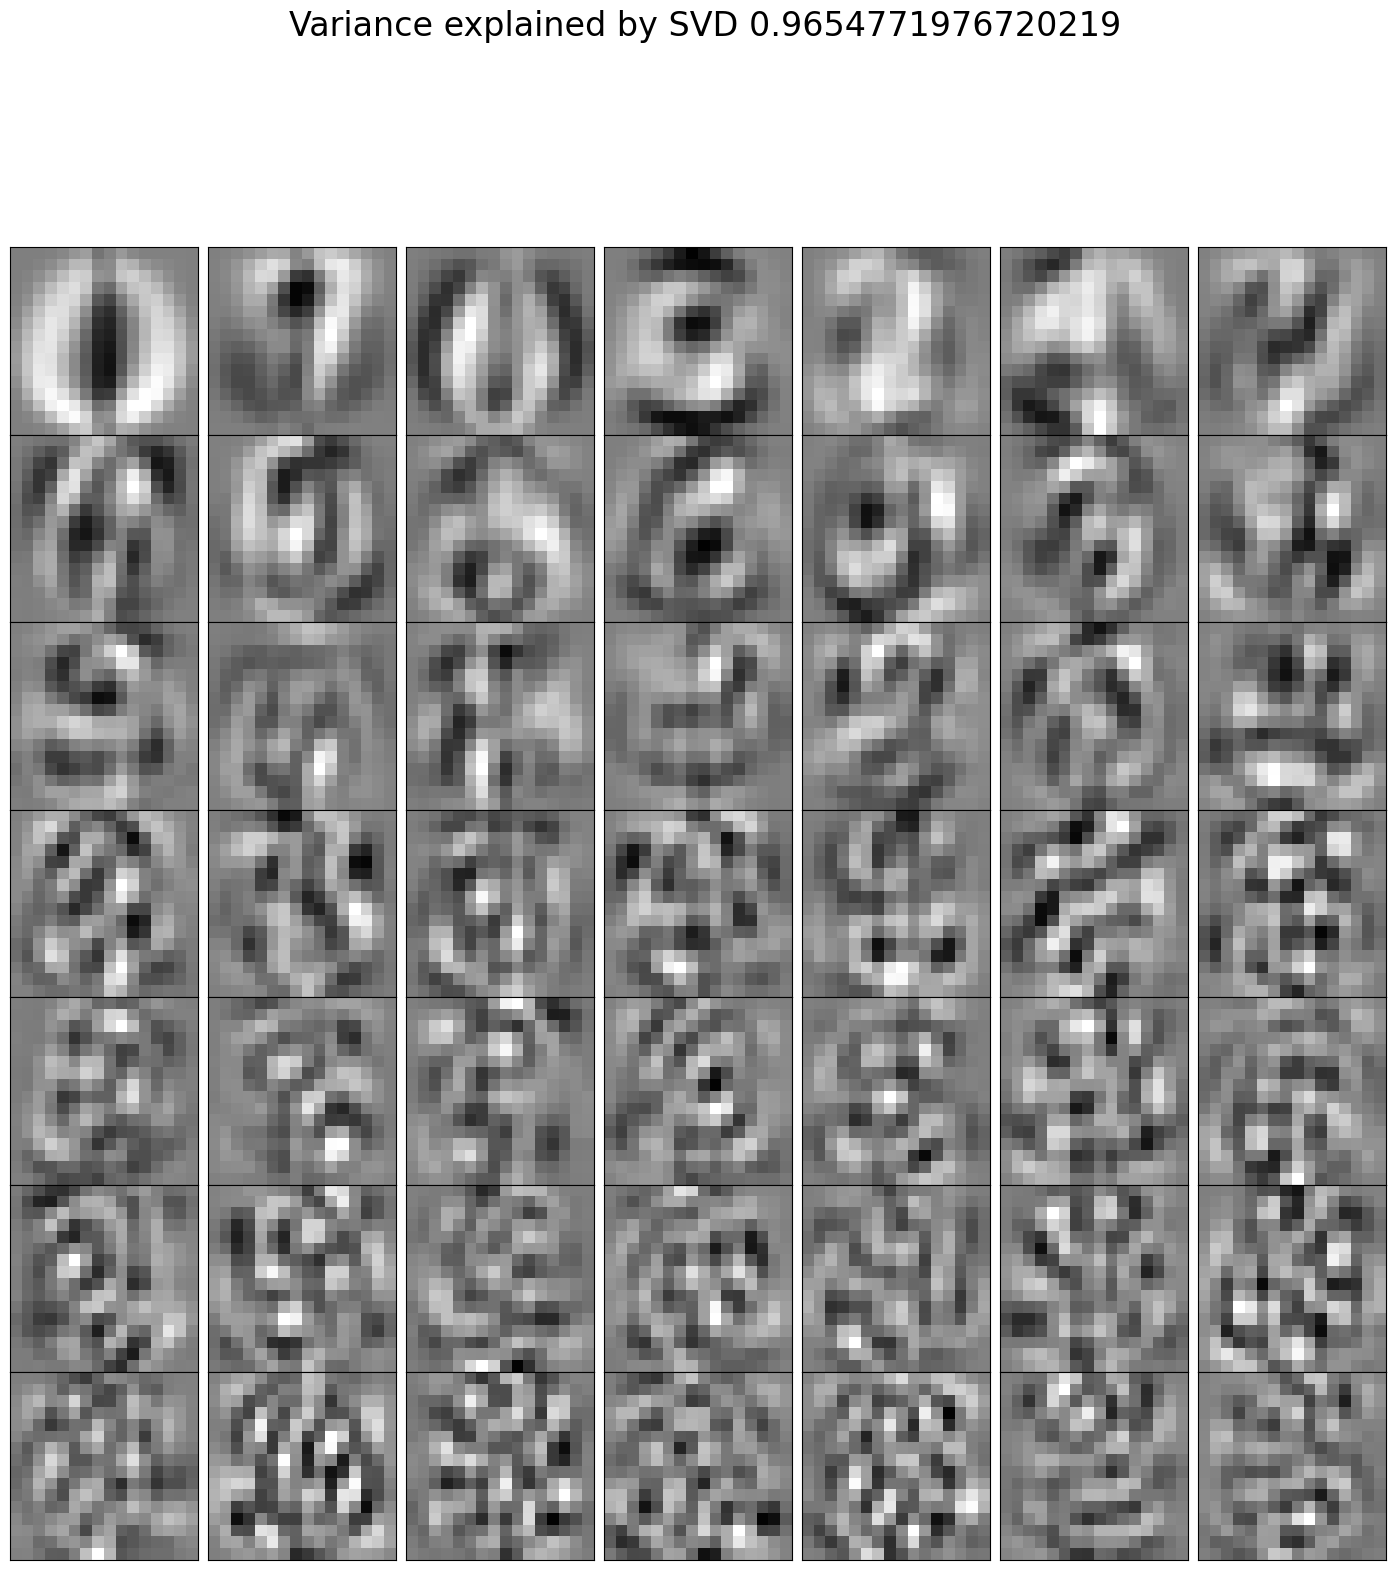

In [ ]:
n_components = 100# num components

SST = np.sum(np.sum(Xtrain**2))

model = decomposition.PCA(n_components=n_components)
# Fit svd with centered data
Xtrain = Xtrain - np.mean(Xtrain)
Xtest = Xtest - np.mean(Xtrain)
model.fit(Xtrain)
components = model.components_
plot_components(f'Variance explained by SVD {model.explained_variance_ratio_.sum()}', components)

### 3 Try analyzing the data with 49 components using at least NMF and AA. What is the qualitative difference between the features extracted by each of the unsupervised learningmethods? Discuss what the benefits/drawbacks of the approaches may be.

In [25]:
np.min(Xtrain)

-0.516935677734375

C:\Users\jonas\AppData\Local\Temp\ipykernel_20604\1559750581.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S


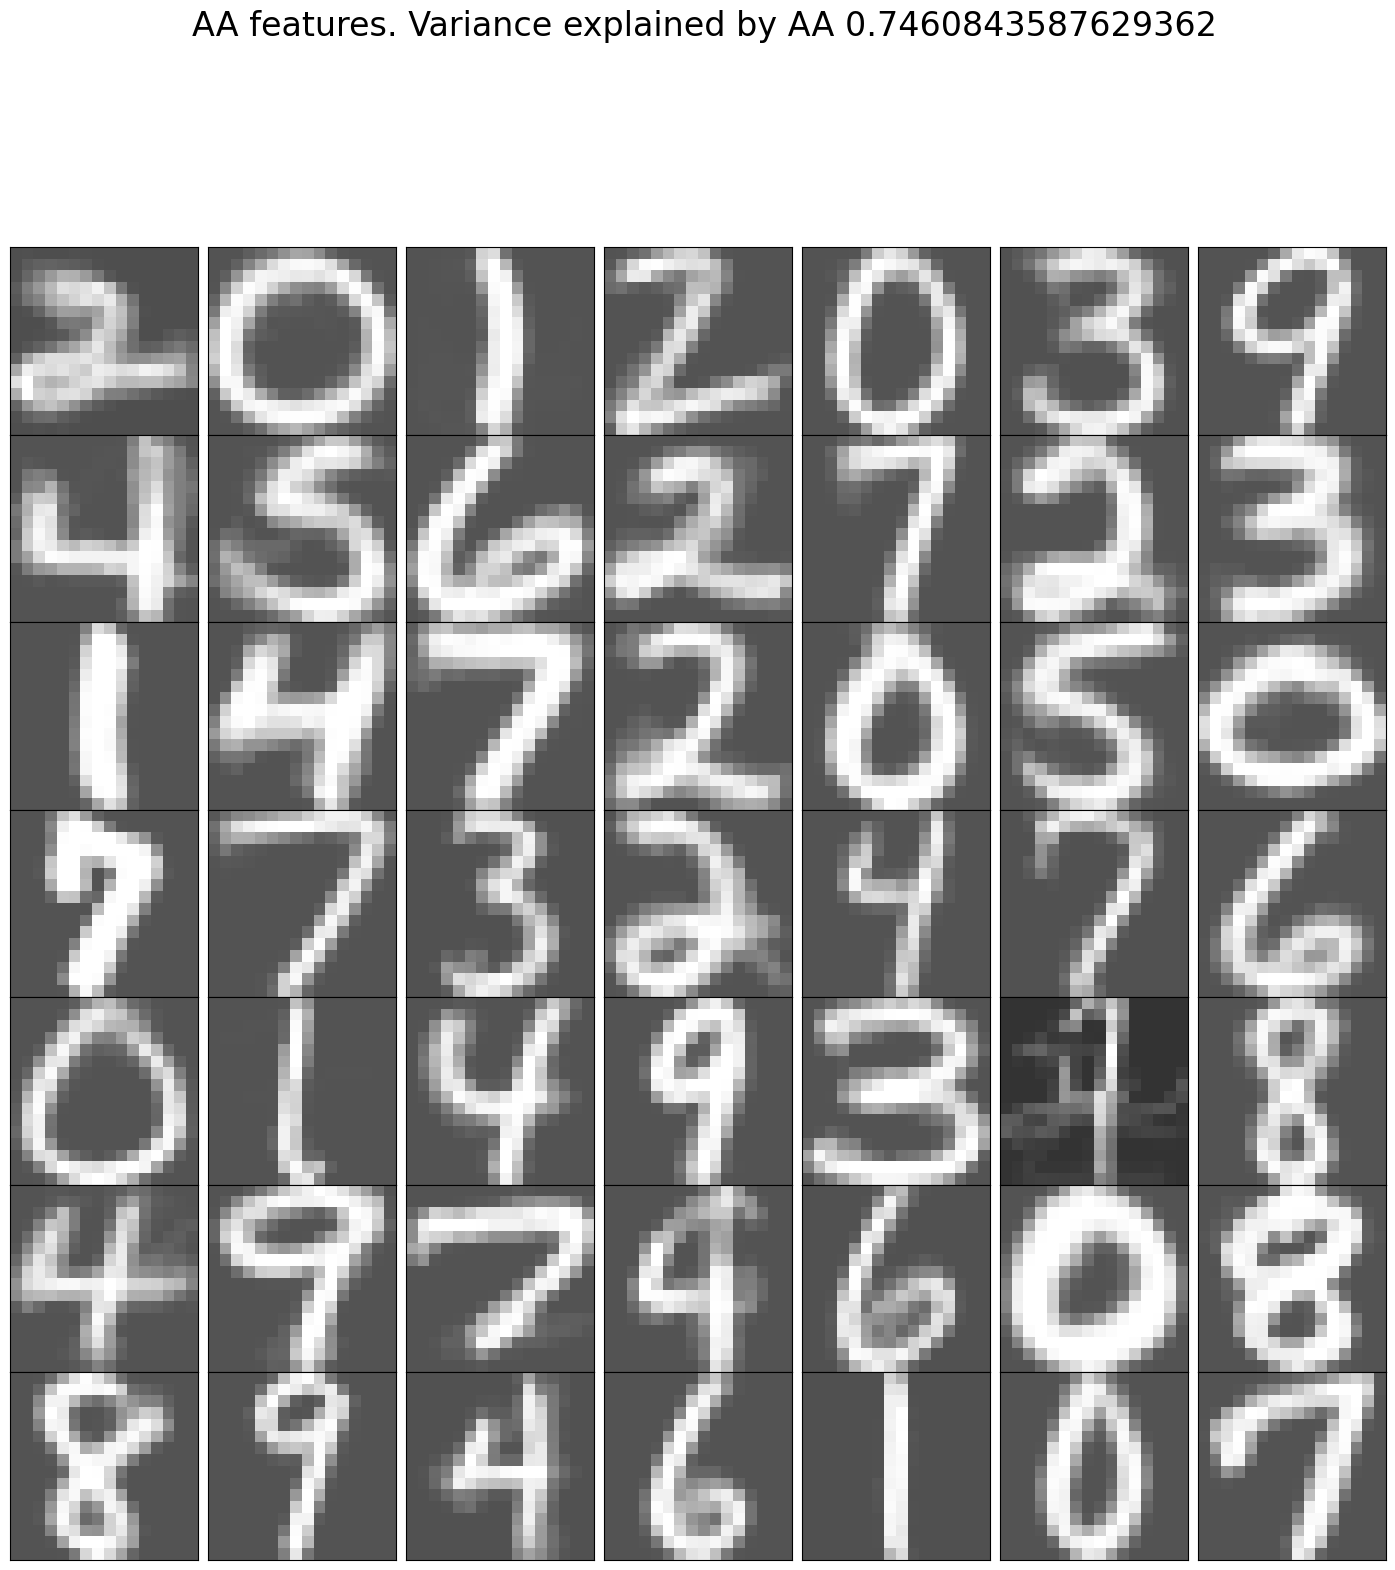

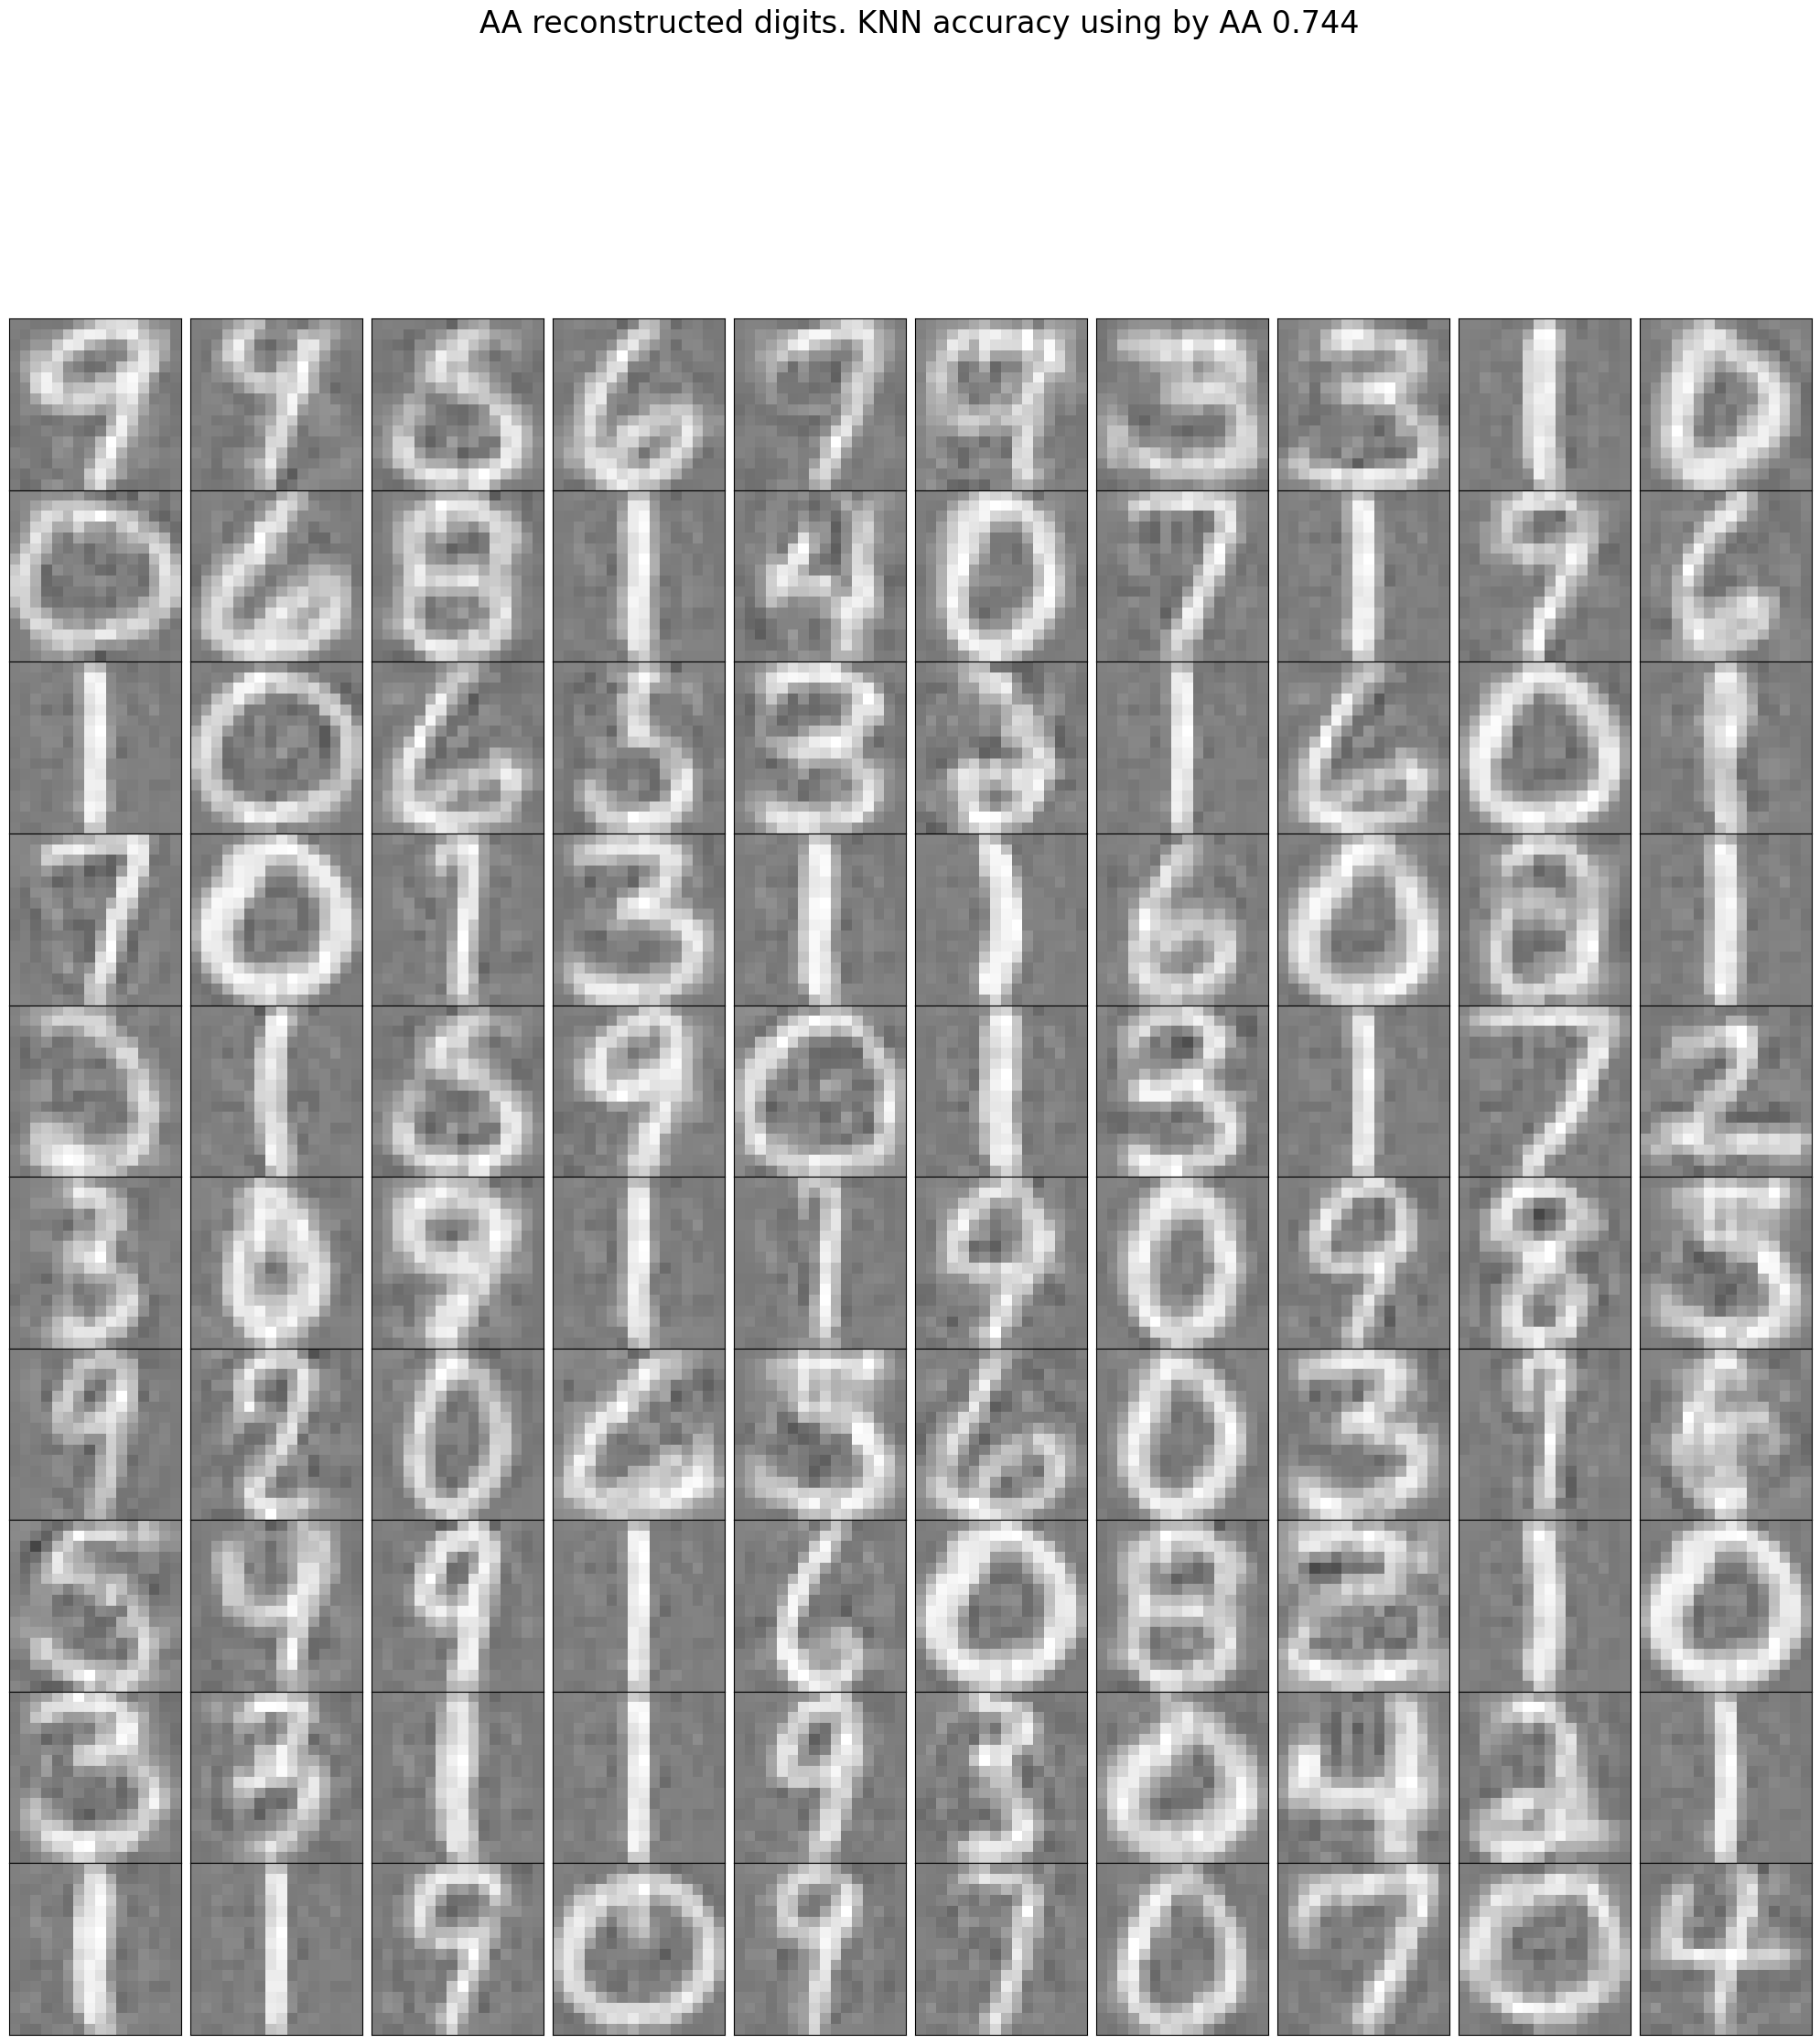

In [30]:
methods = ['SVD','NMF', 'AA', 'SC', 'kmeans']
method= methods[2]

n_components = 49 # num components
knn = KNeighborsClassifier(n_neighbors=k)
if method == 'SVD':
    model = decomposition.PCA(n_components=n_components)
    X_train_transformed = model.fit_transform(Xtrain)
    X_hat = X_train_transformed.dot(model.components_) + model.mean_
    L = 0.5*np.linalg.norm(Xtrain-X_hat)**2
    components = model.components_
    
    knn.fit(X_train_transformed,ytrain)
    acc = knn.score(model.transform(Xtest),ytest)
    X_test_hat = model.transform(Xtest).dot(model.components_) + model.mean_
elif method == 'NMF':
    # Create model init method is set to random
    model = decomposition.NMF(n_components=n_components, init='random', random_state=0)
    X_train_transformed = model.fit_transform(Xtrain + abs(np.min(Xtrain)))
    L = 0.5*model.reconstruction_err_**2
    components = model.components_
    
    knn.fit(X_train_transformed,ytrain)
    acc = knn.score(model.transform(Xtest),ytest)
    X_test_hat = model.transform(Xtest).dot(model.components_)
elif method == 'AA':
    # Does not require that you center data
    XC, S, C, SSE, varexpl = py_pcha.PCHA(Xtrain.T, noc=n_components, delta=0.1)
    X_hat = Xtrain.T @ C @ S
    L = 0.5*np.linalg.norm(Xtrain.T-X_hat)**2
    components = XC.T
    
    knn.fit(np.asarray(S.T), ytrain)
    Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S
    acc = knn.score(np.asarray(Xtest_transform.T), ytest)
    X_test_hat = (XC @ Xtest_transform).T
    
elif method == 'SC':
    model = decomposition.DictionaryLearning(n_components=n_components, alpha=lbda, transform_alpha=lbda, max_iter=100, transform_max_iter=100, fit_algorithm='cd', transform_algorithm='lasso_cd')
    X_train_transformed = model.fit_transform(Xtrain)
    X_hat = X_train_transformed @ model.components_
    L = 0.5*np.linalg.norm(Xtrain-X_hat)**2
    components = model.components_
    
    knn.fit(X_train_transformed,ytrain)
    acc = knn.score(model.transform(Xtest),ytest)
    X_test_hat = model.transform(Xtest) @ model.components_
elif method == 'kmeans':
    model =  KMeans(n_clusters=n_components)
    # Fit model with data
    model.fit(Xtrain)
    components = model.cluster_centers_
    enc = preprocessing.OneHotEncoder(sparse_output=False)
    cluster_affiliation = enc.fit_transform(np.expand_dims(model.labels_,axis=1))
    X_hat = cluster_affiliation @ components
    L = 0.5*np.linalg.norm(Xtrain-X_hat)**2
    
    knn.fit(cluster_affiliation,ytrain)
    cluster_affiliation_test = enc.transform(np.expand_dims(model.predict(Xtest),axis=1))
    acc = knn.score(cluster_affiliation_test,ytest)
    X_test_hat = cluster_affiliation_test @ components
    
plot_components(f'{method} features. Variance explained by {method} {1-2*L/SST}', components)
plot_recons(X_test_hat, f'{method} reconstructed digits. KNN accuracy using by {method} {acc}')